In [ ]:
!pip install wget
!pip install wandb
!pip install xtarfile

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=2546e31844812c5525324ba049b00f8967b1e2d9c8cbfc40cef784eae9080435
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
     |████████████████████████████████| 1.8 MB 5.2 MB/s 
     |████████████████████████████████| 181 kB 74.4 MB/s 
     |████████████████████████████████| 144 kB 87.5 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=37d9be7f79a0074bcfbe872d84f052f34b7f4870c4f56de1729d0da5f0352708
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools
  Created wheel for xtarfile: filename=xtarfile-0.1.0-py3-none-any.whl size=3862 sha256=49f2beda18ebebb2125292c8f64506ba01cca92ea928c4cc9afa3e729fbcda76
  Stored in directory: /root/.cache/pip/wheels/14/ed/

### Configuration

In [ ]:

import os
from os.path import exists
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random 
import numpy as np
import keras
import tensorflow as tf
import xtarfile as tarfile
import csv
class Dataset:
    
    def downloadDataSet(self):
      cwd = os.getcwd()
     
      file_exists = exists('./dakshina_dataset_v1.0.tar')
      if(file_exists==False):
        print('downloading....')
        os.system('curl -SL https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar > dakshina_dataset_v1.0.tar')
        print('download Complete')
      extract_exists = exists('./dakshina_dataset_v1.0/')   
      if(extract_exists==False): 
        print('Extracting..') 
        with tarfile.open('dakshina_dataset_v1.0.tar', 'r') as archive:
            archive.extractall()
        print('Complete')

      print('You are all set')

    def readData(self,dir,start_token="\t",end_token="\n"):
      # Vectorize the data.
      input_texts=list()
      target_texts=list()
      original_input_texts=list()
      original_target_texts=list()
      input_characters = set()
      target_characters = set()
      with open(dir, "r", encoding="utf-8") as f:
        lines = f.read().split("\n")
      
      for line in lines:
          ln = line.split("\t")
          if(len(ln)==3):
            target_text=ln[0].strip()  
            input_text=ln[1].strip()
            original_input_texts.append(input_text)
            original_target_texts.append(target_text)
            target_text = start_token + target_text + end_token
            input_texts.append(input_text)
            target_texts.append(target_text)
            for char in input_text:
              if char not in input_characters:
                input_characters.add(char)
            for char in target_text:
             if char not in target_characters:
               target_characters.add(char)
      input_characters = sorted(list(input_characters))
      target_characters = sorted(list(target_characters))
      return original_input_texts,original_target_texts,input_texts,target_texts,input_characters,target_characters


   

    #def encode_decode_characters(self,train_input, train_target, val_input=[], val_target=[],start_token="\t",end_token="\n"):
    def encode_decode_characters(self,train_input, train_target,start_token="\t",end_token="\n"):
        # Returns the encoding for characters to integer (as a dictionary) and decoding for integers to characters (as a list) for in
        BLANK_CHAR=' '
        # Encoding and decoding of input vocabulary
        input_char_enc = {}
        input_char_dec = []
        max_encoder_seq_length = 1
        tmplist=[]
        for i in train_input:
            tmplist.append(i)
        """for i in val_input:
            tmplist.append(i)"""
        for string in tmplist:
            max_encoder_seq_length = max(max_encoder_seq_length, len(string))
            for char in string:
                if char not in input_char_enc:
                    input_char_enc[char] = len(input_char_dec)
                    input_char_dec.append(char)
        if BLANK_CHAR not in input_char_enc:
            input_char_enc[BLANK_CHAR] = len(input_char_dec)
            input_char_dec.append(BLANK_CHAR)

        # Encoding and decoding of target vocabulary
        target_char_enc = {}
        target_char_dec = []
        target_char_enc[start_token] = len(target_char_dec)
        target_char_dec.append(start_token)
        max_decoder_seq_length = 1
        for string in train_target :#+ val_target:
            max_decoder_seq_length = max(max_decoder_seq_length, len(string)+2)
            for char in string:
                if char not in target_char_enc:
                    target_char_enc[char] = len(target_char_dec)
                    target_char_dec.append(char)
        target_char_enc[end_token] = len(target_char_dec)
        target_char_dec.append(end_token)
        if ' ' not in target_char_enc:
            target_char_enc[BLANK_CHAR] = len(target_char_dec)
            target_char_dec.append(BLANK_CHAR)

        """print("Number of training samples:", len(train_input))
        print("Number of validation samples:", len(val_input))
        print("Number of unique input tokens:", len(input_char_dec))
        print("Number of unique output tokens:", len(target_char_dec))
        print("Max sequence length for inputs:", max_encoder_seq_length)
        print("Max sequence length for outputs:", max_decoder_seq_length)"""

        return input_char_enc, input_char_dec, target_char_enc, target_char_dec, max_encoder_seq_length, max_decoder_seq_length
    def preprocessing(self,input_char_enc, input_char_dec, target_char_enc, target_char_dec,max_encoder_seq_length,max_decoder_seq_length,input_texts,target_texts,start_token="\t",end_token="\n"):
        encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length), dtype="float32")
        decoder_input_data = np.zeros((len(input_texts), max_decoder_seq_length), dtype="float32")
        decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, len(target_char_dec)), dtype="float32")
        for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
            for t, char in enumerate(input_text):
                encoder_input_data[i, t] =input_char_enc[char]
            #encoder_input_data[i, t + 1 :] = input_char_enc[start_token]

            for t, char in enumerate(target_text):
                # decoder_target_data is ahead of decoder_input_data by one timestep
                decoder_input_data[i, t, ] = target_char_enc[char]
                if t > 0:
                    # decoder_target_data will be ahead by one timestep
                    # and will not include the start character.
                    decoder_target_data[i, t - 1, target_char_enc[char]] = 1.0
            decoder_input_data[i, t + 1 :] = target_char_enc[" "]
            decoder_target_data[i, t:, target_char_enc[" "]] = 1.0
        return encoder_input_data,decoder_input_data,decoder_target_data


       
   

## Sequence to sequence RNN

In [ ]:
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.utils.vis_utils import plot_model
class seqTOseq:
  def parameters(self,input_char_dec,target_char_dec,\
                 num_of_encoders=1,\
                 num_of_decoders=1,\
                 latent_dim=64,\
                 inp_emb_size=64,\
                 cell_type="lstm",\
                 cell_activation="tanh",\
                 optimizer="adam",\
                 dropout=0):
      self.num_encoder_tokens=len(input_char_dec)
      self.num_decoder_tokens=len(target_char_dec)
      self.latent_dim=latent_dim
      self.cell_type=cell_type
      self.optimizer=optimizer
      self.num_of_encoders=num_of_encoders
      self.num_of_decoders=num_of_decoders
      self.dropout=dropout
      self.inp_emb_size=inp_emb_size
      self.cell_activation=cell_activation
  def model(self):
      if(self.cell_type=="rnn"):
         cell=keras.layers.SimpleRNN
      if(self.cell_type=="lstm"):
        cell=keras.layers.LSTM     
      if(self.cell_type=="gru"):
         cell=keras.layers.GRU
      # Define an input sequence and process it.
      
      encoder_input = keras.layers.Input(shape=(None,), name="input_1")
      encoder_inp_emb = keras.layers.Embedding(self.num_encoder_tokens, self.inp_emb_size, name="embedding_1")(encoder_input)
      encoder =cell(self.latent_dim, return_state=True,\
                    return_sequences=True,\
                    activation=self.cell_activation,\
                    name="encoder_1",\
                    dropout=self.dropout)        
      
      encoder_outputs, *encoder_states = encoder(encoder_inp_emb)
      for i in range(1,self.num_of_encoders):
        encoder_outputs, *encoder_states = cell(self.latent_dim,\
                                       return_state=True,\
                                       return_sequences=True,\
                                       activation=self.cell_activation,\
                                       dropout=self.dropout,\
                                       name="encoder_"+str(i+1))(
                                                        encoder_outputs,initial_state=encoder_states
                                                 )
      # Set up the decoder, using `encoder_states` as initial state.
      decoder_inputs = keras.Input(shape=(None,), name="input_2")
      #input embedding 
      decoder_inp_emb = keras.layers.Embedding(self.num_decoder_tokens, self.inp_emb_size, name="embedding_2")(decoder_inputs)
      decoder=cell(self.latent_dim ,return_sequences=True,\
                   return_state=True,\
                   name="decoder_1",\
                   activation=self.cell_activation,\
                   dropout=self.dropout)
      decoder_outputs, *decode_states=decoder(decoder_inp_emb, initial_state=encoder_states)
      for i in range(1,self.num_of_decoders):
        decoder_outputs, *decode_states = cell(self.latent_dim,\
                                       return_state=True,\
                                       return_sequences=True,\
                                       activation=self.cell_activation,\
                                       dropout=self.dropout,\
                                       name="decoder_"+str(i+1))(
                                                        decoder_outputs,initial_state=encoder_states)
                                                 
      decoder_dense = keras.layers.Dense(self.num_decoder_tokens, activation="softmax")
      decoder_outputs = decoder_dense(decoder_outputs)
      # Define the model that will turn
      # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
      model = keras.Model([encoder_input, decoder_inputs], decoder_outputs)
      model.compile(optimizer=self.optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
      return model
  def modelSummary(self,model):
      plot_model(model, to_file='encoder_model.png', show_shapes=True)
      f = plt.figure()
      f.set_figwidth(20)
      f.set_figheight(20)
      plt.imshow(mpimg.imread('encoder_model.png'))
      plt.axis('off')


### Read data from dataset

In [ ]:
ds=Dataset()
ds.downloadDataSet()
language='te'
train_dir='./dakshina_dataset_v1.0/'+language+'/lexicons/'+language+'.translit.sampled.train.tsv'
val_dir='./dakshina_dataset_v1.0/'+language+'/lexicons/'+language+'.translit.sampled.dev.tsv'
test_dir='./dakshina_dataset_v1.0/'+language+'/lexicons/'+language+'.translit.sampled.test.tsv'


You are all set


### Preprocessing data

In [ ]:
train_original_input_texts,train_original_target_texts,train_ip_txt,train_op_txt,train_ip_chr,train_op_chr=ds.readData(train_dir)
val_original_input_texts,val_original_target_texts,val_ip_txt,val_op_txt,val_ip_chr,val_op_chr=ds.readData(val_dir)
test_original_input_texts,test_original_target_texts,test_ip_txt,test_op_txt,test_ip_chr,test_op_chr=ds.readData(test_dir)

In [ ]:
"""input_char_enc, input_char_dec,\
 target_char_enc,\
target_char_dec,\
max_encoder_seq_length,\
max_decoder_seq_length\
=ds.encode_decode_characters(train_ip_txt, train_op_txt, val_ip_txt, val_op_txt)"""

input_char_enc, input_char_dec,\
target_char_enc,\
target_char_dec,\
max_encoder_seq_length,\
max_decoder_seq_length\
=ds.encode_decode_characters(train_ip_txt, train_op_txt)

##### Assigning training, validation and test encoder input, decoder input, decoder output

In [ ]:

train_enc_input, train_dec_input, train_dec_target\
= ds.preprocessing(input_char_enc, input_char_dec, target_char_enc, target_char_dec,max_encoder_seq_length,max_decoder_seq_length,train_ip_txt, train_op_txt)



In [ ]:
val_enc_input, val_dec_input, val_dec_target = \
ds.preprocessing(input_char_enc, input_char_dec, target_char_enc, target_char_dec,\
                 max_encoder_seq_length,max_decoder_seq_length,val_ip_txt, val_op_txt)


test_enc_input, test_dec_input, test_dec_target =\
 ds.preprocessing(input_char_enc, input_char_dec, target_char_enc, target_char_dec,max_encoder_seq_length,max_decoder_seq_length\
                  ,test_ip_txt, test_op_txt)


### Call the model

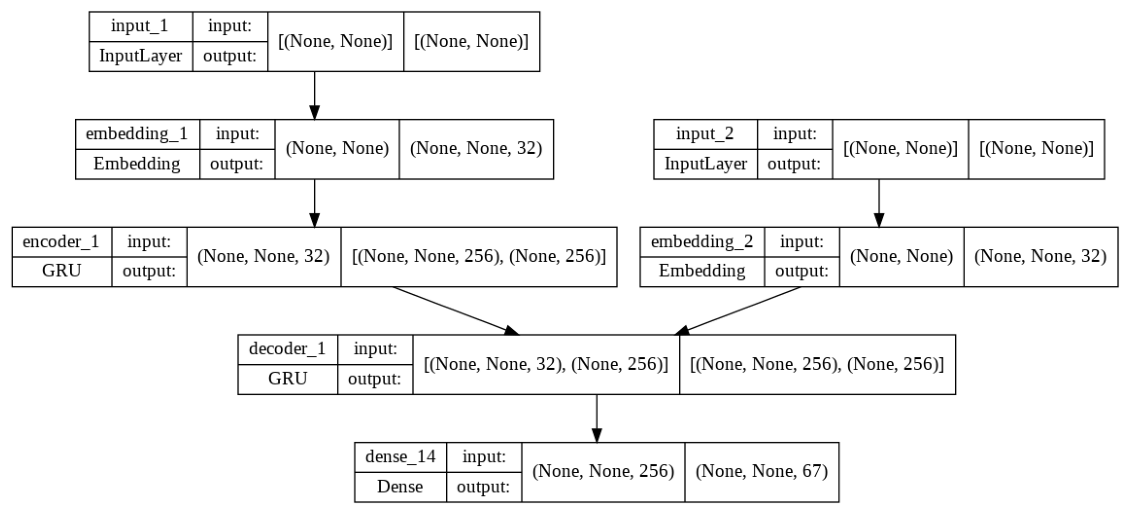

In [ ]:
batch_size = 32  # Batch size for training.
epochs = 15  # Number of epochs to train for.
seq=seqTOseq()
seq.parameters(input_char_dec=input_char_dec,\
               target_char_dec=target_char_dec,\
               num_of_encoders=1,\
               num_of_decoders=1,
               latent_dim=256,\
               inp_emb_size=32,\
               cell_type="gru",\
               cell_activation="tanh",\
               optimizer="adam",\
               dropout=.3)

model=seq.model()
seq.modelSummary(model)

#### Train the model

In [ ]:
model.fit(
    [train_enc_input, train_dec_input],
    train_dec_target,
    batch_size=batch_size,
    epochs=100,
   validation_data=([val_enc_input, val_dec_input ] ,val_dec_target)
)


Epoch 1/100
1830/1830 [==============================] - 18s 8ms/step - loss: 0.9673 - accuracy: 0.7345 - val_loss: 0.7297 - val_accuracy: 0.7943
Epoch 2/100
1830/1830 [==============================] - 14s 8ms/step - loss: 0.6749 - accuracy: 0.8021 - val_loss: 0.5192 - val_accuracy: 0.8442
Epoch 3/100
1830/1830 [==============================] - 14s 8ms/step - loss: 0.4735 - accuracy: 0.8573 - val_loss: 0.3798 - val_accuracy: 0.8864
Epoch 4/100
1830/1830 [==============================] - 14s 8ms/step - loss: 0.3424 - accuracy: 0.8964 - val_loss: 0.2861 - val_accuracy: 0.9133
Epoch 5/100
1830/1830 [==============================] - 14s 8ms/step - loss: 0.2522 - accuracy: 0.9238 - val_loss: 0.2317 - val_accuracy: 0.9300
Epoch 6/100
1830/1830 [==============================] - 15s 8ms/step - loss: 0.1944 - accuracy: 0.9410 - val_loss: 0.1969 - val_accuracy: 0.9404
Epoch 7/100
1830/1830 [==============================] - 15s 8ms/step - loss: 0.1565 - accuracy: 0.9524 - val_loss: 0.1748 -

KeyboardInterrupt: ignored

In [ ]:
predicted_data=model.predict([test_enc_input, test_dec_input ])

In [ ]:
key_list = list(target_char_enc.keys())
val_list = list(target_char_enc.values())

targetpredicted=[]
itr=0
for data in predicted_data:
  wordip=test_ip_txt[itr]
  itr+=1
  wordop=""
  for i in data:
    
    index=np.argmax(i)
    position = val_list.index(index)
    wordop+=key_list[position]
  
  wordop=wordop.replace('\t', '')
  wordop=wordop.replace('\n', '')
  wordop=wordop.replace(' ', '')
  targetpredicted.append(wordop)
  


In [ ]:
for i in range(len(targetpredicted)):
  print(test_original_input_texts[i]+"   "+test_original_target_texts[i]+"  "+targetpredicted[i])

amkamlo   అంకంలో  అంకంలో
ankamlo   అంకంలో  అంకంలో
ankamloo   అంకంలో  అంకంలో
amkitamai   అంకితమై  అంకితమై
ankitamai   అంకితమై  అంకితమై
ankela   అంకెల  అంకెల్
ankelanu   అంకెలను  అంకేలను
angeekarinchaka   అంగీకరించక  అంగీకాించక
amgiikarimchaadu   అంగీకరించాడు  అంగీకాించాడు
angeekarinchaadu   అంగీకరించాడు  అంగీకాించాడు
angiikarinchaadu   అంగీకరించాడు  అంగీకాించాడు
angeekarinchaali   అంగీకరించాలి  అంగీకాించాలి
angikarinchaali   అంగీకరించాలి  అంగీకరించాలి
angeekarinchi   అంగీకరించి  అంగీకాించి
angikarinchi   అంగీకరించి  అంగీకరించి
angeekarimchina   అంగీకరించిన  అంగీకాించిన
angeekarinchina   అంగీకరించిన  అంగీకాించిన
angeekarinche   అంగీకరించే  అంగీకాించే
angikarinchay   అంగీకరించే  అంగీకాించే
angikarinche   అంగీకరించే  అంగీకరించే
antaarani   అంటారని  అంతారని
antarani   అంటారని  అంతరరని
antaavaa   అంటావా  అంటవవ్
antava   అంటావా  అంటవవ్
andar   అండర్  అందర్
ander   అండర్  అందర్
undar   అండర్  ఉందర్
under   అండర్  ఉందర్
amtagaa   అంతగా  అంతగా
antagaa   అంతగా  అంతగా
anthagaa   అంతగా  అంతగా
antam

In [ ]:
count=0
countTot=0
for i in range(len(targetpredicted)):
  countTot+=1
  if(test_original_target_texts[i]==targetpredicted[i]):
    count+=1


In [ ]:
print(str(countTot)+" "+str(count))

5747 2109


In [ ]:
model.save("s2s")

In [ ]:
model = keras.models.load_model("s2s")


In [ ]:
num_encoder_tokens=len(input_char_dec)
num_decoder_tokens=len(target_char_dec)
latent_dim=256
input_char_enc 
input_token_index = input_char_enc
target_token_index = target_char_enc

In [ ]:
model = keras.models.load_model("s2s")


In [ ]:
encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.get_layer('encoder_1').output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)


In [ ]:

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(256))
decoder_state_input_c = keras.Input(shape=(256))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.get_layer('decoder_1')
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)


ValueError: ignored

In [ ]:

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence